In [1]:
# sefa manipulation from projected W+ latent

In [2]:
import copy
import os
import os.path as osp
import re
from tqdm import tqdm
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F

import legacy
from face_alignment import image_align
from landmarks_detector import LandmarksDetector
from sefa import factorize_weight
from projector import project

In [3]:
# set device
device = torch.device('cuda:3')
# set model paths
ckptbasedir = '/workspace/stylegan3encoder/ckpts/'
network_pkl = osp.join(ckptbasedir, 'stylegan3-t-ffhq-1024x1024.pkl')
landmark_ckpt_path = osp.join(ckptbasedir, 'dlib', 'shape_predictor_68_face_landmarks.dat') # for target
VGG16url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'

In [4]:
# load models
landmark_detector = LandmarksDetector(landmark_ckpt_path)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
with dnnlib.util.open_url(VGG16url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)

In [5]:
src_latent_base = np.load('data/tmp/src_latent_base.npy')
src_latent_right = np.load('data/tmp/src_latent_right.npy')
src_latent_young = np.load('data/tmp/src_latent_young.npy')
target_latent = np.load('data/tmp/target.npy')

In [6]:
younger_direction = src_latent_young - src_latent_base
younger_direction = younger_direction / np.linalg.norm(younger_direction)

right_direction = src_latent_right - src_latent_base
right_direction = right_direction / np.linalg.norm(right_direction)

In [7]:
# factorize weight
distances = np.linspace(0,60,4)
layers, boundaries, values = factorize_weight(G)

In [8]:
lst = []
for boundary_ind in range(len(boundaries)):
#for boundary_ind in range(1):
    cos_sim_sum = 0
    for direction_ind in [1,2]:
        b = torch.from_numpy(boundaries)[boundary_ind]
        d = torch.from_numpy(younger_direction)[0][direction_ind]
        cos_sim = torch.nn.CosineSimilarity(dim=0, eps=1e-08)(d,b)
        cos_sim_sum += cos_sim
    lst.append(cos_sim_sum)
young_semantic_ind = lst.index(max(lst))

lst = []
for boundary_ind in range(len(boundaries)):
#for boundary_ind in range(1):
    cos_sim_sum = 0
    for direction_ind in [1,2]:
        b = torch.from_numpy(boundaries)[boundary_ind]
        d = torch.from_numpy(right_direction)[0][direction_ind]
        cos_sim = torch.nn.CosineSimilarity(dim=0, eps=1e-08)(d,b)
        cos_sim_sum += cos_sim
    lst.append(cos_sim_sum)
right_semantic_ind = lst.index(max(lst))

In [9]:
young_boundary = boundaries[young_semantic_ind:young_semantic_ind+1]
right_boundary = boundaries[right_semantic_ind:right_semantic_ind+1]

In [10]:
codes = target_latent

In [11]:
imgs = []
for dist in distances:
    temp_code = copy.deepcopy(codes)
    temp_code[:,[1,2],:] += young_boundary * dist
    img = G.synthesis(torch.from_numpy(temp_code).to(device), noise_mode='const', force_fp32=True)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((128,128))) #.save(f'{outdir}/{fn}.png')

for dist in distances:
    temp_code = copy.deepcopy(codes)
    temp_code[:,[1,2],:] += right_boundary * dist
    img = G.synthesis(torch.from_numpy(temp_code).to(device), noise_mode='const', force_fp32=True)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgs.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((128,128))) #.save(f'{outdir}/{fn}.png')
    

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


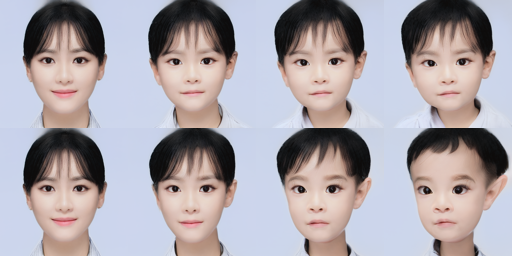

In [12]:
gw, gh = (4, 2)
H, W = (128,128)
result = np.stack(imgs)
result = result.reshape(gh, gw, H, W, 3)
result = result.transpose(0,2,1,3,4)
result = result.reshape(gh * H, gw * W, 3)
display(PIL.Image.fromarray(result, 'RGB'))